# Intangibles in Pratts

## Import libraries

In [1]:
import numpy as np
import datetime
import pandas as pd
import warnings
pd.set_option('display.max_rows', 500)
import seaborn as sns
sns.set(color_codes=True)
pd.options.display.float_format = '{:.3f}'.format
warnings.filterwarnings('ignore')
import statsmodels.formula.api as sm


## Import PrattStats Data

In [2]:
data=pd.read_csv('prattsdatabase.csv',encoding='latin-1')    
f = {'IntanglibleIntensityPPA':['count','mean','median','std']}
f2 = {'RelGoodwillIntensityPPA':['count','mean','median','std']}


## Read Price Index data

In [3]:

GDPDeflator=pd.read_csv('GDPDEFAnnual.csv',encoding='latin-1')  
GDPDeflator=GDPDeflator[:-1]
GDPDeflator.year=GDPDeflator.year.astype(int)
data['year'] = data['SaleDate'].str[-4:]
data['year']=data['year'].astype(int)
data['pricedef'] = data['year'].map(GDPDeflator.set_index('year')['GDPDEF2007'])
data['RealNetSales']=data.NetSales/data.pricedef


In [4]:
data['IntanglibleIntensityPPA']=data.TotalIntangiblesPPA/data.TotalAssetsPPA
data['NonCompete'][data['NonCompete']=='Yes']=1.0
data['NonCompete'][data['NonCompete']=='No']=0.0
data['NetIncomeOverSalePrice']=(data.EarningsBeforeTaxes/data.MVICPrice)*100
data['IdentifiableIntanglibleIntensityPPA']=100*data.TotalIdentifiableIntangiblesPPA/data.TotalAssetsPPA
data['TotalIntangiblesFAPPARatio']=100*data['TotalIntangiblesPPA']/(data['TotalIntangiblesPPA']+data['FixedAssetsPPA'])
data['GoodwillIntensityPPA']=100*data.GoodwillPPA/data.TotalAssetsPPA
data['IntanglibleIntensityPPA']=100*data.TotalIntangiblesPPA/data.TotalAssetsPPA
data['logIntant']=np.log(data.TotalIntangiblesPPA)
data['TargetAge2']=data['TargetAge']**2
data['IntanglibleSales']=100*data.TotalIntangiblesPPA/data.NetSales

data['RelGoodwillIntensityPPA']=100*(data['GoodwillIntensityPPA']/data['IntanglibleIntensityPPA'])
data['FixedIntensityPPA']=100*data.FixedAssetsPPA/data.TotalAssetsPPA
data['FixedAssetsBM']=100*data.FixedAssets/data.FixedAssetsPPA

data['LeveragePPA']=data.InterestBearingLiabilitiesPPA/data.TotalAssetsPPA
data['Leverage']=data.LongTermLiabilities/data.TotalAssets
data['Leverage'][np.isinf(data['Leverage'])]=np.nan
data['wgt_sales']=data.NetSales/data.NetSales.sum()

In [5]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,25989,25990,25991,25992,25993,25994,25995,25996,25997,25998
Unnamed: 0,0,1,2,3,4,5,6,7,8,9,...,25989,25990,25991,25992,25993,25994,25995,25996,25997,25998
TransactionId,34198,33428,11952,1309,20651,26059,18579,10845,17117,16163,...,38851,4681,17416,11426,2708,38794,31292,6326,1231,7762
TargetSIC1,139,139,139,139,161,161,171,171,172,173,...,9431,9431,9441,9441,9511,9512,9532,9621,9651,9661
TargetSIC2,273.000,5148.000,5191.000,NaN,2099.000,5153.000,5159.000,5159.000,2084.000,5159.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TargetSIC3,NaN,NaN,5172.000,NaN,2023.000,NaN,NaN,NaN,5182.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TargetSICGeneral,100,100,100,100,100,100,100,100,100,100,...,9400,9400,9400,9400,9500,9500,9500,9600,9600,9600
TargetNAICS1,113000000000.000,111000000000.000,111000000000.000,112000000000.000,111000000000.000,111000000000.000,111000000000.000,111000000000.000,111000000000.000,111000000000.000,...,923000000000.000,923000000000.000,923000000000.000,923000000000.000,924000000000.000,924000000000.000,925000000000.000,926000000000.000,926000000000.000,927000000000.000
TargetNAICS2,NaN,424000000000.000,425000000000.000,NaN,312000000000.000,425000000000.000,425000000000.000,425000000000.000,312000000000.000,425000000000.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TargetNAICS3,NaN,NaN,425000000000.000,NaN,312000000000.000,NaN,NaN,NaN,425000000000.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TargetNAICSGeneral,112000,111000,111000,111000,111000,111000,111000,111000,111000,111000,...,923000,923000,923000,923000,924000,924000,925000,926000,926000,927000


### Add labels for Legal type and NAICS 

In [6]:
naics_labels=['Agriculture, Forestry, Fishing and Hunting',\
        'Mining, Quarrying, and Oil and Gas Extraction',\
        'Utilities',\
        'Construction',\
        'NA1',\
        'Manufacturing',\
        'NA2',\
        'Wholesale Trade',\
        'Retail Trade',\
        'NA3',\
        'Transportation and Warehousing',\
        'NA4',\
        'Information',\
        'Finance and Insurance',\
        'Real Estate and Rental and Leasing',\
        'Professional, Scientific, and Technical Services',\
        'Management of Companies and Enterprises',\
        'Administrative and Support and Waste Management and Remediation Services'\
        'NA5',\
        'Educational Services',\
        'Health Care and Social Assistance',\
        'Arts, Entertainment, and Recreation',\
        'Accommodation and Food Service',\
        'Other Services','Public administration']

len(naics_labels)

naics_code=[11,21,22,23,24,31,35,42,44,46,48,50,51,52,53,54,55,56,61,62,71,72,81,83,92]
n=24


#naics_labels=['Ag. Mining and Utilities',\
#        'Consts and Mfg',\
#        'Trade and warehousing',\
#        'Information and FIRE',\
#        'RE',\
#        'Professional services',\
#        'Nonprof services']

#naics_code=[11,23,42,51,53,54,57,92]

data['TargetStructureAlt']=data['TargetStructure'].values
sel=data['TargetStructure'].isin(['Partnership', 'Limited Partnership', 'LLP'])
data.loc[sel,'TargetStructureAlt']='Partnership'
sel=data['TargetStructure'].isin(['Consolidated', 'UK Corporation', 'PC','Non-Profit','Ltd','Limited Corporation'])
data.loc[sel,'TargetStructureAlt']='Others'
sel=data['TargetStructure'].isin(['C corporation'])
data.loc[sel,'TargetStructureAlt']='C Corporation'
data['naics_label']=pd.cut(data['TargetNAICS1']/10**10,naics_code[:n+1],labels=naics_labels[:n],include_lowest=True,right=False)
data['naics_code_cat']=pd.cut(data['TargetNAICS1']/10**10,naics_code[:n+1],include_lowest=True,right=False)
data['naics_2d']=pd.cut(data['TargetNAICS1']/10**10,naics_code[:n+1],labels=naics_code[:n],include_lowest=True,right=False)





In [7]:
data['TargetStructure'].unique()

array(['LLC', 'C Corporation', nan, 'S Corporation',
       'Limited Corporation', 'Sole Proprietorship', 'LLP',
       'Consolidated', 'Ltd', 'Partnership', 'Limited Partnership',
       'UK Corporation', 'C corporation', 'Non-Profit', 'PC'],
      dtype=object)

### Sample selection
Mainly I am taking away outliers

In [8]:
cutoffH=data.MVICPrice.quantile(0.99)
cutoffL=data.MVICPrice.quantile(0.01)
cutoffHNI=data.EarningsBeforeTaxes.quantile(.999999)
cutoffLNI=data.EarningsBeforeTaxes.quantile(0.00001)
cutoffTAH=data.TotalAssetsPPA.quantile(0.99)
cutoffTAL=data.TotalAssetsPPA.quantile(0.01)
selection=(data.MVICPrice.notnull())&(data.MVICPrice<cutoffH)&((data.MVICPrice>0))&((data.MVICPrice>cutoffL)) &(data.EarningsBeforeTaxes<cutoffHNI)&(data.EarningsBeforeTaxes>cutoffLNI)&(data.TotalAssetsPPA<cutoffTAH)&(data.TotalAssetsPPA>cutoffTAL)
sel=data['TargetStructureAlt'].isin(['C Corporation','S Corporation', 'Sole Proprietorship', 'Partnership','LLC'])
selection=selection&sel
selPassThru=data['TargetStructureAlt'].isin(['S Corporation', 'Sole Proprietorship', 'Partnership'])
data['TargetStructurePassThru']=data['TargetStructure'].values
data.loc[selPassThru,'TargetStructurePassThru']=True
data.loc[~selPassThru,'TargetStructurePassThru']=False
selPassThru=data['TargetStructureAlt'].isin(['S Corporation', 'Sole Proprietorship', 'Partnership','LLC'])
data['TargetStructurePassThruLLC']=data['TargetStructure'].values
data.loc[selPassThru,'TargetStructurePassThruLLC']=True
data.loc[~selPassThru,'TargetStructurePassThruLLC']=False
data['TargetStructureBus']=data['TargetStructure'].values
data.loc[sel,'TargetStructureBus']='all_bus'

In [9]:
var='RealNetSales'
index='naics_code_cat'
columns='TargetStructureAlt'
pd.pivot_table(data[selection], values=var, aggfunc='count',index=index,columns=columns).to_csv('rawcounts_naics.csv')
pd.pivot_table(data[selection], values=var, aggfunc='sum',index=index,columns=columns).to_csv('saleswgtcounts_naics.csv')


## Descriptive Stats for Intangible Intensity

In [10]:
data[selection][['IntanglibleIntensityPPA']].describe().to_csv('intant_int_summary.csv')

In [11]:
data[selection][['IntanglibleIntensityPPA']].groupby(data[selection].naics_code_cat).agg(f).to_csv('NAICS.csv')

In [12]:
data[selection][['IntanglibleIntensityPPA']].groupby(data[selection].TargetStructureAlt).agg(f).to_csv('LFO.csv')

In [13]:
data[selection][['IntanglibleIntensityPPA']].groupby(data[selection].TargetStructurePassThru).agg(f)

IntanglibleIntensityPPA                     
                                          count   mean median    std
TargetStructurePassThru                                             
False                                      3837 56.870 62.028 32.611
True                                       6695 58.446 64.545 31.572

In [14]:
data[selection][['IntanglibleIntensityPPA']].groupby(data[selection].TargetStructurePassThruLLC).agg(f)

IntanglibleIntensityPPA                     
                                             count   mean median    std
TargetStructurePassThruLLC                                             
False                                         1887 57.860 62.692 32.035
True                                          8645 57.875 63.833 31.948

In [15]:
var='IntanglibleIntensityPPA'
index='naics_code_cat'
columns='TargetStructureAlt'
pd.pivot_table(data[selection], values=var, aggfunc=f,index=index,columns=columns).to_csv('intan_int.csv')
print(pd.pivot_table(data[selection], values=var, aggfunc=f,index=index,columns=columns))

                           count                                    \
TargetStructureAlt C Corporation     LLC Partnership S Corporation   
naics_code_cat                                                       
[11, 21)                   3.000   5.000       1.000         9.000   
[21, 22)                   9.000   6.000       2.000         5.000   
[22, 23)                   5.000   2.000         nan         8.000   
[23, 24)                  50.000  61.000       6.000       287.000   
[31, 35)                 389.000 138.000      17.000       541.000   
[42, 44)                   2.000   5.000         nan        12.000   
[44, 46)                 283.000 241.000      34.000      1012.000   
[48, 50)                  43.000  42.000       3.000       245.000   
[51, 52)                 188.000  63.000       3.000       101.000   
[52, 53)                  49.000  22.000       3.000       114.000   
[53, 54)                  84.000  99.000       8.000       139.000   
[54, 55)            

In [16]:
var='IntanglibleIntensityPPA'
index='naics_code_cat'
columns='TargetStructurePassThru'
pd.pivot_table(data[selection], values=var, aggfunc=f,index=index,columns=columns).to_csv('intan_int_passthru.csv')
print(pd.pivot_table(data[selection], values=var, aggfunc=f,index=index,columns=columns))

                        count         mean        median           std       
TargetStructurePassThru False True   False  True   False  True   False  True 
naics_code_cat                                                               
[11, 21)                    8    11 42.567 27.251 56.540 24.300 35.696 22.041
[21, 22)                   15     7 28.022 50.209 26.024 38.993 24.469 25.692
[22, 23)                    7     8 47.785 61.637 51.436 72.500 29.992 36.961
[23, 24)                  111   320 63.390 69.663 68.285 74.346 26.124 39.791
[31, 35)                  527   643 54.061 54.737 57.586 59.829 30.547 28.742
[42, 44)                    7    12 58.114 54.414 63.902 48.634 28.775 27.764
[44, 46)                  524  1293 51.778 54.421 54.559 58.670 30.493 29.669
[48, 50)                   85   279 58.530 68.096 62.162 75.000 27.793 24.626
[51, 52)                  251   120 82.006 79.623 89.336 86.842 23.593 23.788
[52, 53)                   71   127 64.371 88.570 81.974 95.812 

In [17]:
var='IntanglibleIntensityPPA'
index='naics_code_cat'
columns='TargetStructurePassThruLLC'
pd.pivot_table(data[selection], values=var, aggfunc=f,index=index,columns=columns).to_csv('intan_int_passthru_llc.csv')
print(pd.pivot_table(data[selection], values=var, aggfunc=f,index=index,columns=columns))

                           count         mean        median           std  \
TargetStructurePassThruLLC False True   False  True   False  True   False   
naics_code_cat                                                              
[11, 21)                       3    16 51.149 30.428 60.606 35.230 47.137   
[21, 22)                       9    13 29.297 39.086 26.024 36.647 19.700   
[22, 23)                       5    10 43.972 60.773 51.436 66.558 34.073   
[23, 24)                      50   381 58.845 69.255 65.196 74.312 24.350   
[31, 35)                     389   781 53.721 54.787 57.266 59.257 30.411   
[42, 44)                       2    17 63.902 54.821 63.902 52.147  0.000   
[44, 46)                     283  1534 49.072 54.505 48.903 59.354 29.563   
[48, 50)                      43   321 61.519 66.444 67.261 74.261 28.162   
[51, 52)                     188   183 81.264 81.205 88.054 90.463 25.074   
[52, 53)                      49   149 62.388 85.649 77.806 95.714 36.573   

In [18]:
data[selection]['IntanglibleIntensityPPA'].describe()

count   10532.000
mean       57.872
std        31.962
min       -51.829
25%        33.814
50%        63.623
75%        84.860
max       631.818
Name: IntanglibleIntensityPPA, dtype: float64

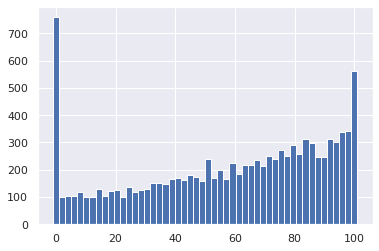

In [19]:
data[selection]['IntanglibleIntensityPPA'].hist(bins=50,range=(-1,101))

In [20]:
import statsmodels.api as sm
#dummies1 = pd.get_dummies(data['naics_code_cat']).rename(columns=lambda x: 'nacis_code_cat' + str(x))
#dummies2 = pd.get_dummies(data['year']).rename(columns=lambda x: 'year' + str(x))
X = pd.concat([data[['TargetAge','TargetAge2']]], axis=1)
Y=np.log(data.TotalIntangiblesPPA)
X = sm.add_constant(X)
selection=(pd.notnull(data.TargetAge)) &(pd.notnull(data.TotalIntangiblesPPA) ) & (data.TotalIntangiblesPPA>0)& ~(data.TargetStructureAlt=='C Corporation')
model11 = sm.OLS(Y[selection], X[selection]).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     TotalIntangiblesPPA   R-squared:                       0.018
Model:                             OLS   Adj. R-squared:                  0.018
Method:                  Least Squares   F-statistic:                     80.99
Date:                 Sat, 13 Jun 2020   Prob (F-statistic):           1.43e-35
Time:                         15:42:19   Log-Likelihood:                -17943.
No. Observations:                 8607   AIC:                         3.589e+04
Df Residuals:                     8604   BIC:                         3.591e+04
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4054      0.035    322.008      0.000      11.336      11.475
TargetAge      0.0258      0.002     11.819      0.000       0.021       0.030
TargetAge2 -8.265e-05   1.59e-05     -5.208      0.000      -0.000   -5.15e-05
==============================================================================
Omnibus:                     1644.055   Durbin-Watson:                   1.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7281.017
Skew:                           0.871   Prob(JB):                         0.00
Kurtosis:                       7.155   Cond. No.                     3.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
dummies1 = pd.get_dummies(data['naics_code_cat']).rename(columns=lambda x: 'nacis_code_cat' + str(x))
dummies2 = pd.get_dummies(data['year']).rename(columns=lambda x: 'year' + str(x))
X = pd.concat([data[['TargetAge','TargetAge2']],dummies1,dummies2],axis=1)
Y=np.log(data.TotalIntangiblesPPA)
X = sm.add_constant(X)
selection=(pd.notnull(data.TargetAge)) &(pd.notnull(data.TotalIntangiblesPPA) ) & (data.TotalIntangiblesPPA>0)& ~(data.TargetStructureAlt=='C Corporation')
model11 = sm.OLS(Y[selection], X[selection]).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     TotalIntangiblesPPA   R-squared:                       0.236
Model:                             OLS   Adj. R-squared:                  0.232
Method:                  Least Squares   F-statistic:                     58.75
Date:                 Sat, 13 Jun 2020   Prob (F-statistic):               0.00
Time:                         15:44:52   Log-Likelihood:                -16865.
No. Observations:                 8607   AIC:                         3.382e+04
Df Residuals:                     8561   BIC:                         3.415e+04
Df Model:                           45                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     11.2272      0.960     11.693      0.000       9.345      13.109
TargetAge                  0.0169      0.002      8.518      0.000       0.013       0.021
TargetAge2             -4.637e-05   1.42e-05     -3.270      0.001   -7.42e-05   -1.86e-05
nacis_code_cat[11, 21)     0.2525      1.099      0.230      0.818      -1.902       2.407
nacis_code_cat[21, 22)     4.4811      1.087      4.123      0.000       2.351       6.612
nacis_code_cat[22, 23)    -0.2470      1.191     -0.207      0.836      -2.583       2.089
nacis_code_cat[23, 24)     0.2224      1.001      0.222      0.824      -1.740       2.185
nacis_code_cat[24, 31) -4.691e-15   2.95e-14     -0.159      0.874   -6.25e-14    5.32e-14
nacis_code_cat[31, 35)     0.6615      0.999      0.662      0.508      -1.298       2.620
nacis_code_cat[35, 42)  2.244e-15   1.15e-14      0.195      0.845   -2.03e-14    2.48e-14
nacis_code_cat[42, 44)    -0.9709      1.087     -0.893      0.372      -3.101       1.160
nacis_code_cat[44, 46)    -0.7390      0.998     -0.740      0.459      -2.696       1.218
nacis_code_cat[46, 48)  1.068e-14   9.42e-15      1.133      0.257   -7.79e-15    2.91e-14
nacis_code_cat[48, 50)    -0.3017      1.002     -0.301      0.763      -2.265       1.662
nacis_code_cat[50, 51)  9.061e-15   1.73e-14      0.523      0.601   -2.49e-14     4.3e-14
nacis_code_cat[51, 52)     2.3662      1.005      2.355      0.019       0.397       4.336
nacis_code_cat[52, 53)     0.7913      1.007      0.786      0.432      -1.182       2.765
nacis_code_cat[53, 54)    -0.1870      1.003     -0.187      0.852      -2.152       1.778
nacis_code_cat[54, 55)     0.8193      1.001      0.819      0.413      -1.142       2.781
nacis_code_cat[55, 56)     6.4695      1.137      5.690      0.000       4.241       8.698
nacis_code_cat[56, 61)    -0.5017      0.999     -0.502      0.615      -2.460       1.456
nacis_code_cat[61, 62)    -0.9277      1.011     -0.918      0.359      -2.910       1.054
nacis_code_cat[62, 71)    -0.1758      1.001     -0.176      0.861      -2.138       1.787
nacis_code_cat[71, 72)    -0.8380      1.007     -0.833      0.405      -2.811       1.135
nacis_code_cat[72, 81)    -1.2648      0.998     -1.267      0.205      -3.221       0.692
nacis_code_cat[81, 83)    -1.3000      0.999     -1.302      0.193      -3.258       0.657
nacis_code_cat[83, 92)  2.572e-16   6.81e-15      0.038      0.970   -1.31e-14    1.36e-14
year1990                6.135e-15   1.19e-14      0.515      0.607   -1.72e-14    2.95e-14
year1991                6.661e-16   6.84e-15      0.097      0.922   -1.27e-14    1.41e-14
year1992                2.094e-15   4.16e-15      0.503      0.615   -6.07e-15    1.03e-14
year1993                  -1.2132      1.173     -1.035      0.301   

### Counts

In [21]:
print(pd.pivot_table(data[selection], values=var, aggfunc='count',index=index,columns=columns))

TargetStructurePassThruLLC   False    True 
naics_code_cat                             
[11, 21)                     4.000    9.000
[21, 22)                     5.000   11.000
[22, 23)                       nan    7.000
[23, 24)                    13.000  355.000
[31, 35)                    93.000  656.000
[42, 44)                       nan   16.000
[44, 46)                    91.000 1350.000
[48, 50)                    26.000  298.000
[51, 52)                    42.000  137.000
[52, 53)                    16.000  134.000
[53, 54)                    42.000  235.000
[54, 55)                    47.000  398.000
[55, 56)                     2.000    8.000
[56, 61)                    86.000  968.000
[61, 62)                     4.000  101.000
[62, 71)                    39.000  359.000
[71, 72)                    11.000  139.000
[72, 81)                   159.000 1304.000
[81, 83)                    86.000  972.000


### Means

In [22]:
print(pd.pivot_table(data[selection], values=var, aggfunc='mean',index=index,columns=columns))

TargetStructurePassThruLLC  False  True 
naics_code_cat                          
[11, 21)                   52.897 37.051
[21, 22)                   49.186 54.728
[22, 23)                      nan 70.442
[23, 24)                   62.593 71.529
[31, 35)                   58.393 57.444
[42, 44)                      nan 58.248
[44, 46)                   52.811 56.882
[48, 50)                   67.462 67.494
[51, 52)                   80.657 81.774
[52, 53)                   69.003 87.108
[53, 54)                   78.944 81.097
[54, 55)                   76.089 82.125
[55, 56)                   67.032 60.004
[56, 61)                   72.185 74.749
[61, 62)                   76.007 62.044
[62, 71)                   63.474 66.625
[71, 72)                   37.814 51.006
[72, 81)                   53.517 48.654
[81, 83)                   47.195 51.237


### Median

In [23]:
print(pd.pivot_table(data[selection], values=var, aggfunc='median',index=index,columns=columns))

TargetStructurePassThruLLC  False  True 
naics_code_cat                          
[11, 21)                   49.636 47.059
[21, 22)                   47.342 45.509
[22, 23)                      nan 85.000
[23, 24)                   64.286 75.942
[31, 35)                   63.047 61.580
[42, 44)                      nan 59.573
[44, 46)                   51.988 60.587
[48, 50)                   81.151 74.759
[51, 52)                   86.538 91.549
[52, 53)                   89.671 95.801
[53, 54)                   89.628 94.286
[54, 55)                   85.040 90.546
[55, 56)                   67.032 64.005
[56, 61)                   77.636 80.365
[61, 62)                   89.062 75.605
[62, 71)                   65.530 72.202
[71, 72)                   25.455 50.740
[72, 81)                   51.000 48.983
[81, 83)                   43.980 50.000


## Descriptive Stats for Fixed AssetsPPA/ Total AssetsPPA

In [24]:
var='FixedIntensityPPA'
index='naics_label'
columns='TargetStructureAlt'

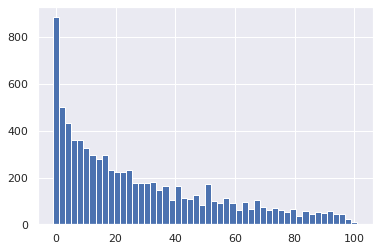

In [25]:
data[selection][var].hist(bins=50,range=(-1,101))

### Counts

In [26]:
print(pd.pivot_table(data[selection], values=var, aggfunc='count',index=index,columns=columns))

TargetStructureAlt                                     LLC  Others  \
naics_label                                                          
Agriculture, Forestry, Fishing and Hunting           2.000   2.000   
Mining, Quarrying, and Oil and Gas Extraction        5.000   1.000   
Utilities                                              nan     nan   
Construction                                        55.000   6.000   
Manufacturing                                      101.000  17.000   
Wholesale Trade                                      4.000     nan   
Retail Trade                                       215.000  56.000   
Transportation and Warehousing                      35.000  15.000   
Information                                         40.000   9.000   
Finance and Insurance                               16.000   7.000   
Real Estate and Rental and Leasing                  88.000  32.000   
Professional, Scientific, and Technical Services    85.000  19.000   
Management of Compan

### Means

In [27]:
print(pd.pivot_table(data[selection], values=var, aggfunc='mean',index=index,columns=columns))

TargetStructureAlt                                    LLC  Others  \
naics_label                                                         
Agriculture, Forestry, Fishing and Hunting         15.374   5.310   
Mining, Quarrying, and Oil and Gas Extraction      25.457  44.615   
Utilities                                             nan     nan   
Construction                                       20.542  18.013   
Manufacturing                                      23.313  23.950   
Wholesale Trade                                    11.555     nan   
Retail Trade                                       21.169  24.291   
Transportation and Warehousing                     34.668  32.006   
Information                                         9.387  10.041   
Finance and Insurance                              11.553   0.730   
Real Estate and Rental and Leasing                  9.650  12.752   
Professional, Scientific, and Technical Services   10.012   9.416   
Management of Companies and Enterp

### Median

In [28]:
print(pd.pivot_table(data[selection], values=var, aggfunc='count',index=index,columns=columns))

TargetStructureAlt                                     LLC  Others  \
naics_label                                                          
Agriculture, Forestry, Fishing and Hunting           2.000   2.000   
Mining, Quarrying, and Oil and Gas Extraction        5.000   1.000   
Utilities                                              nan     nan   
Construction                                        55.000   6.000   
Manufacturing                                      101.000  17.000   
Wholesale Trade                                      4.000     nan   
Retail Trade                                       215.000  56.000   
Transportation and Warehousing                      35.000  15.000   
Information                                         40.000   9.000   
Finance and Insurance                               16.000   7.000   
Real Estate and Rental and Leasing                  88.000  32.000   
Professional, Scientific, and Technical Services    85.000  19.000   
Management of Compan

## Descriptive Stats for Fixed Assets/ Fixed AssetsPPA

In [29]:
var='FixedAssetsBM'
index='naics_label'
columns='TargetStructureAlt'
sel_alt=selection & data.FixedAssetsPPA>0

count     867.000
mean      235.182
std      1316.465
min         0.000
25%        38.062
50%        96.230
75%       120.723
max     34566.787
Name: FixedAssetsBM, dtype: float64


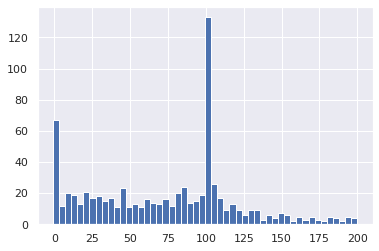

In [30]:
data[selection][var].hist(bins=50,range=(-1,200))
print (data[sel_alt][var].describe()) 

### Count

In [31]:
print(pd.pivot_table(data[sel_alt], values=var, aggfunc='count',index=index,columns=columns))

TargetStructureAlt                                    LLC  Others  \
naics_label                                                         
Agriculture, Forestry, Fishing and Hunting          1.000   0.000   
Mining, Quarrying, and Oil and Gas Extraction       4.000   1.000   
Utilities                                             nan     nan   
Construction                                       11.000   1.000   
Manufacturing                                      25.000   8.000   
Wholesale Trade                                     0.000     nan   
Retail Trade                                       12.000   0.000   
Transportation and Warehousing                      7.000   1.000   
Information                                        17.000   3.000   
Finance and Insurance                               7.000   1.000   
Real Estate and Rental and Leasing                  3.000   0.000   
Professional, Scientific, and Technical Services   31.000   6.000   
Management of Companies and Enterp

### Mean

In [32]:
print(pd.pivot_table(data[sel_alt], values=var, aggfunc='mean',index=index,columns=columns))

TargetStructureAlt                                     LLC  Others  \
naics_label                                                          
Agriculture, Forestry, Fishing and Hunting          75.010     nan   
Mining, Quarrying, and Oil and Gas Extraction       63.625 104.737   
Utilities                                              nan     nan   
Construction                                       452.172  40.897   
Manufacturing                                      133.382  96.679   
Wholesale Trade                                        nan     nan   
Retail Trade                                       121.263     nan   
Transportation and Warehousing                     302.620  81.220   
Information                                        175.436 116.012   
Finance and Insurance                               92.901  88.263   
Real Estate and Rental and Leasing                 877.630     nan   
Professional, Scientific, and Technical Services   198.681  93.947   
Management of Compan

### Median

In [33]:
print(pd.pivot_table(data[sel_alt], values=var, aggfunc='median',index=index,columns=columns))

TargetStructureAlt                                     LLC  Others  \
naics_label                                                          
Agriculture, Forestry, Fishing and Hunting          75.010     nan   
Mining, Quarrying, and Oil and Gas Extraction       73.782 104.737   
Utilities                                              nan     nan   
Construction                                       104.485  40.897   
Manufacturing                                       84.530 100.000   
Wholesale Trade                                        nan     nan   
Retail Trade                                       100.000     nan   
Transportation and Warehousing                     198.511  81.220   
Information                                        100.000 103.264   
Finance and Insurance                              100.000  88.263   
Real Estate and Rental and Leasing                 676.193     nan   
Professional, Scientific, and Technical Services   100.000 100.000   
Management of Compan

## Disaggregated  Itemps from the  PPA
### Stocks are  reported as a percentage of total assets declared in the PPA 8594

### Market value of Invested capital (MVIC)
Also known as the selling price, the MVIC is the total consideration paid to the seller and includes any cash, notes and/or securities that were used as a form of payment plus any interest-bearing liabilities assumed by the buyer. The MVIC price includes the noncompete value and the assumption of interest-bearing liabilities and excludes (1) the real estate value and (2) any earnouts (because they have not yet been earned, and they may not be earned) and (3) the employment/consulting agreement values. 

In [34]:
var='PriceAssetsRatio'
data[var]=data['MVICPrice']/data['TotalAssetsPPA']*100
f = {var:['count','mean','median','std']}
print (data[selection][[var]].groupby(data.TargetStructureAlt).agg(f))

                    PriceAssetsRatio                      
                               count   mean  median    std
TargetStructureAlt                                        
LLC                             1641 97.368 100.000 12.047
Others                           412 97.550 100.000 10.581
Partnership                      140 96.895 100.000 11.642
S Corporation                   4708 97.897 100.000 17.821
Sole Proprietorship              971 98.180 100.000 11.171


### Tangible Assets
* **Cash and Equivalents PPA** : All cash, marketable securities, and other near-cash items acquired. Excludes sinking funds. Cash equivalents (NOW accounts and money market funds) must be available upon demand in order to justify inclusion.

* **Accounts Receivable PPA** :  accounts from trade, net of allowance for doubtful accounts, that were acquired.
* **Inventory PPA** : Anything constituting inventory for the firm including raw material, work in progress, and finished goods that were acquired. Those items of tangible property which are held for sale in the normal course of business, are in the process of being produced for such purposes, or are to be used in the production of such items.
* **Other Current Assets PPA** : Any other current assets that were acquired, excluding Cash and Equivalents PPA, Trade Receivables PPA, and Inventory PPA.
* **Fixed Assets PPA** : All property, plant, leasehold improvements and equipment acquired, net of accumulated depreciation or depletion.
* **Real Estate PPA** : The value placed on any real estate acquired in the sale of the business. The real estate value is not included in the MVIC.

In [35]:
varlist=['CashAndEquivalentsPPA','AccountsReceivablePPA','InventoryPPA','OtherCurrentAssetsPPA','FixedAssetsPPA','RealEstatePPA','OtherNonCurrentAssetsPPA']
for var in varlist:
    varname=var+'AssetRatio'
    data[varname]=data[var]/data['TotalAssetsPPA']*100
    f = {varname:['count','mean','median','std']}
    print (data[selection][[varname]].groupby(data.TargetStructureAlt).agg(f))

                    CashAndEquivalentsPPAAssetRatio                   
                                              count  mean median   std
TargetStructureAlt                                                    
LLC                                            1590 0.196  0.000 1.973
Others                                          405 0.334  0.000 1.857
Partnership                                     138 0.038  0.000 0.244
S Corporation                                  4626 0.172  0.000 3.778
Sole Proprietorship                             965 0.018  0.000 0.261
                    AccountsReceivablePPAAssetRatio                   
                                              count  mean median   std
TargetStructureAlt                                                    
LLC                                            1512 0.870  0.000 4.829
Others                                          388 1.088  0.000 5.501
Partnership                                     125 0.636  0.000 3.203
S Corp

### Intangible Assets
* **Customer Relationships / Lists PPA** :The value attributed to any customer relationships or customer list acquired as part of the acquisition.																		
* **Backlog PPA** :Any acquired purchase orders or booked sales on orders that have not been fully completed. 																		
* **Developed / Existing Technology PPA** :Any acquired developed/completed technology, core technology, and/or acquired or purchased technology. Technology that is in the process of being developed is included in In-Process R&D.																		
* **In-Process R&D PPA** :	Intangible assets acquired relating to any uncompleted/in process research and development.																		
* **Trade Names / Trademarks PPA** :	The value of acquired trademarks/service marks to identify and/or differentiate goods and services or business trade names. 																		
Noncompete Agreements PPA	The value placed on an agreement with the selling party not to compete with the purchaser, usually for a certain period of time and usually in a specified geographic area. 																		
* **Other Intangibles PPA** :	Any other intangible asset acquired that is not listed in the preceding fields. 																		
							
* **Goodwill PPA**	Represents the excess of the aggregate purchase price over the fair value of net assets of the acquired business.																		

In [36]:
varlist=['CustomerRelationshipsListsPPA','BacklogPPA','DevelopedExistingTechnologyPPA','InProcessRandDPPA','TradeNamesTradeMarksPPA','NonCompeteAgreementsPPA','OtherIntangiblesPPA','GoodwillPPA']
for var in varlist:
    varname=var+'AssetRatio'
    data[varname]=data[var]/data['TotalAssetsPPA']*100
    f = {varname:['count','mean','median','std']}
    print (data[selection][[varname]].groupby(data.TargetStructureAlt).agg(f))

                    CustomerRelationshipsListsPPAAssetRatio               \
                                                      count  mean median   
TargetStructureAlt                                                         
LLC                                                    1075 1.811  0.000   
Others                                                   34 9.475  0.000   
Partnership                                              72 2.425  0.000   
S Corporation                                          2357 0.955  0.000   
Sole Proprietorship                                     629 0.043  0.000   

                            
                       std  
TargetStructureAlt          
LLC                  9.567  
Others              21.990  
Partnership         10.760  
S Corporation        6.552  
Sole Proprietorship  0.788  
                    BacklogPPAAssetRatio                   
                                   count  mean median   std
TargetStructureAlt                     

### Liabilities
* **Interest-Bearing Liabilities PPA** :	The value of all interest-bearing liabilities assumed. In addition to long-term debt, includes the current portion of long-term debt, as well as any other current liability bearing interest.																		
* **Total Liabilities PPA** :	The sum of all the seller's liabilities assumed by the buyer. 																		

In [37]:
varlist=['InterestBearingLiabilitiesPPA','TotalLiabilitiesPPA']
for var in varlist:
    varname=var+'AssetRatio'
    data[varname]=data[var]/data['TotalAssetsPPA']*100
    f = {varname:['count','mean','median','std']}
    print (data[selection][[varname]].groupby(data.TargetStructureAlt).agg(f))

                    InterestBearingLiabilitiesPPAAssetRatio                   
                                                      count  mean median   std
TargetStructureAlt                                                            
LLC                                                    1181 0.340  0.000 3.451
Others                                                  100 0.478  0.000 2.487
Partnership                                              86 0.004  0.000 0.038
S Corporation                                          2698 0.354  0.000 4.924
Sole Proprietorship                                     650 0.169  0.000 2.143
                    TotalLiabilitiesPPAAssetRatio                    
                                            count  mean median    std
TargetStructureAlt                                                   
LLC                                          1217 1.526  0.000  7.742
Others                                        107 5.209  0.000 11.954
Partnership       

## Items from Income Statement

### All items are reported as  percentage of Gross Profit, which is NetSales - CostOfGoodsSold
### I require the numerator and denominator to be positive
* **Net Sales**: 	Annual Gross sales, net of returns and discounts allowed, if any.																		
* **Cost of Goods Sold**: 	The cost of the inventory items sold during the year. Net of any discounts, returns or write-offs.																		
* **Gross Profit** :	[Net Sales] - [Cost of Goods Sold]																		
* **Rent** :	Annual cost of occupying all space necessary for operation of the business.																		
* **Owner's Compensation** :	Annual income, salary or wage paid to one business owner.																		
* **Other Operating Expense** :	All selling and general and administrative expenses, excluding Rent, Owner's Compensation, and Depreciation/Amortization.																		
* **Depreciation/Amortization** :	Annual decrease in value due to wear and tear, decay or decline in the price of a tangible and/or intangible asset.										
* **Operating Profit** :	[Gross Profit] - [Total Operating Expenses]																		
* **Interest Expense** :	Cost of borrowing expressed as an annual dollar amount. (Does not include interest earnings. If the company had interest earnings, you will find that value in the Interest Income field.)																		

In [38]:
varlist=['NetSales','Rent','OwnersCompensation','DepreciationAmortization','OtherOperatingExpenses','InterestExpense','OperatingProfit']
for var in varlist:
    ind=(data[var]>0) & (data['GrossProfit']>0)
    sel_alt=selection&ind
    f = {var:['count','mean','median','std']}
    print ((100*data[sel_alt][var]/data[sel_alt]['GrossProfit']).groupby(data[sel_alt].TargetStructureAlt).agg(f))

                    NetSales                        
                       count    mean  median     std
TargetStructureAlt                                  
LLC                     1655 196.074 146.116 219.423
Others                   463 205.832 142.105 330.719
Partnership              141 187.663 152.679 100.548
S Corporation           4935 214.402 151.326 317.459
Sole Proprietorship      995 192.310 143.055 241.125
                     Rent                     
                    count   mean median    std
TargetStructureAlt                            
LLC                  1180 15.314 12.727 12.268
Others                147 14.957 13.203 11.479
Partnership            91 18.399 14.845 13.596
S Corporation        2978 13.071 10.347 12.378
Sole Proprietorship   622 19.715 14.691 41.287
                    OwnersCompensation                     
                                 count   mean median    std
TargetStructureAlt                                         
LLC                 

In [39]:
data['rent_book_assets']=data['Rent']/(data['FixedAssets']+data['RealEstate'])
varlist=['rent_book_assets']
for var in varlist:
    ind= (data['Rent']>0)
    sel_alt=selection&ind
    f = {var:['count','mean','median','std']}
    print ((100*data[sel_alt][var]).groupby(data[sel_alt].TargetStructureAlt).agg(f))

                    rent_book_assets                   
                               count   mean  median std
TargetStructureAlt                                     
LLC                              121    inf  60.284 nan
Others                             1 23.545  23.545 nan
Partnership                       10    inf 247.183 nan
S Corporation                    373    inf  92.943 nan
Sole Proprietorship               27    inf 299.021 nan


In [40]:
varlist=['OperatingProfit','GrossProfit']
for var in varlist:
    varname=var+'AssetRatio'
    data[varname]=data[var]/data['TotalIntangiblesPPA']*100
    f = {varname:['count','mean','median','std']}
    print (data[selection][[varname]].groupby(data.TargetStructureAlt).agg(f))

                    OperatingProfitAssetRatio                          
                                        count     mean median       std
TargetStructureAlt                                                     
LLC                                      1659 1259.024 48.870 77534.892
Others                                    466  280.727 67.964  1216.171
Partnership                               142  120.377 37.632   432.734
S Corporation                            4944  119.947 40.533  2720.599
Sole Proprietorship                       994  412.589 61.172  8329.818
                    GrossProfitAssetRatio                             
                                    count      mean  median        std
TargetStructureAlt                                                    
LLC                                  1661 23020.422 211.930 559633.115
Others                                464  1227.706 258.138   5439.820
Partnership                           141   479.104 189.396   1018.41

In [41]:
var='RelGoodwillIntensityPPA'
f = {var:['count','mean','median','std']}
print (data[selection][[var]].groupby(data.TargetStructureAlt).agg(f))
print(data[selection& ~(data.TargetStructureAlt=='C Corporation')]['RelGoodwillIntensityPPA'].describe())

                    RelGoodwillIntensityPPA                      
                                      count   mean  median    std
TargetStructureAlt                                               
LLC                                    1237 85.773 100.000 27.324
Others                                   47 53.630  54.801 33.929
Partnership                              78 74.288  83.654 28.587
S Corporation                          2627 85.215 100.000 26.397
Sole Proprietorship                     655 80.030  90.769 24.989
count   4868.000
mean      83.004
std       27.501
min      -38.889
25%       75.000
50%       99.188
75%      100.000
max      100.000
Name: RelGoodwillIntensityPPA, dtype: float64
